
# Computer Vision: Feature Detection and Matching

**Project Objectives**  
This project focuses on **feature detection** and **feature matching** using OpenCV.

**Learning Objectives**
- Understand the concept of image features and detection methods
- Implement feature detection with **Canny Edge**, **SIFT**, and **Hough Transform**
- Implement feature matching with **Brute Force** and **FLANN**

**Dataset**
- Image path: `/anvil/projects/tdm/data/icecream/hd/images/13_hd.png`


In [3]:
# Setup & Imports

import os, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

IMAGE_PATH = "/anvil/projects/tdm/data/icecream/hd/images/13_hd.png"

image_opencv = cv2.imread(IMAGE_PATH) # BGR
image_rgb = cv2.cvtColor(image_opencv, cv2.COLOR_BGR2RGB)  # for Matplotlib display
image_gray = cv2.cvtColor(image_opencv, cv2.COLOR_BGR2GRAY)


---
## Question 1 

**Task:**  
1) Display the original image (**RGB**)  
2) Display the **grayscale** image  
3) Apply **Canny Edge Detection** (tune thresholds) and display

**Deliverables**
- Original (RGB), Grayscale, Canny results


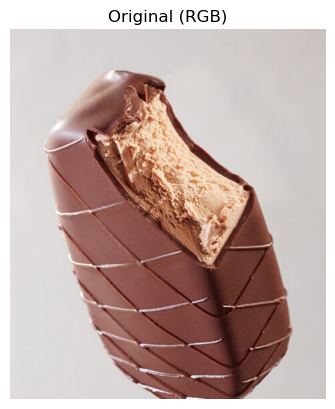

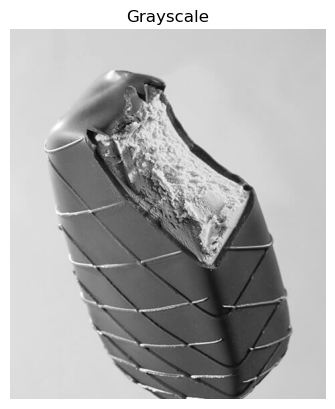

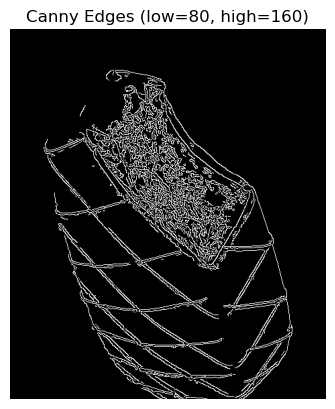

In [5]:
# Display original (RGB)
plt.imshow(image_rgb)
plt.title("Original (RGB)")
plt.axis('off')
plt.show()

# Display grayscale
plt.imshow(image_gray, cmap='gray')
plt.title("Grayscale")
plt.axis('off')
plt.show()

# Canny Edge Detection
low_thresh  = 80   
high_thresh = 160 
canny_edges = cv2.Canny(image_gray, threshold1=low_thresh, threshold2=high_thresh, apertureSize=3)

plt.imshow(canny_edges, cmap='gray')
plt.title(f"Canny Edges (low={low_thresh}, high={high_thresh})")
plt.axis('off')
plt.show()

---
## Question 2 

**Task:** Run **Probabilistic Hough Line Transform** on the **edge image from Q1**, draw detected lines on the original **RGB** image, and display.  
- Tune `threshold` (try 0–150), and optionally `minLineLength`, `maxLineGap`  
- Explain your parameter choices and observations


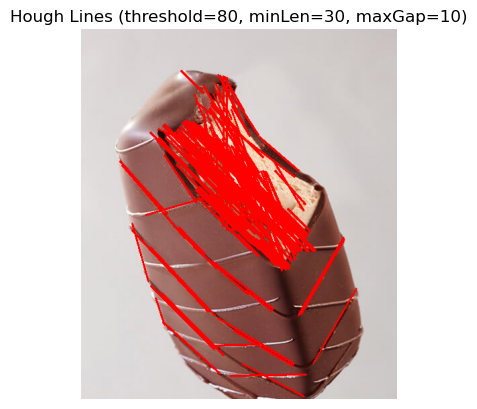

In [8]:
# Make a copy to draw on
vis_lines = image_rgb.copy()

# Parameters
rho = 1
theta = np.pi / 180
threshold = 80   
minLineLength = 30      
maxLineGap = 10     

linesP = cv2.HoughLinesP(canny_edges, rho, theta, threshold=threshold,
                         minLineLength=minLineLength, maxLineGap=maxLineGap)

if linesP is not None:
    for line in linesP:
        x0,y0,x1,y1 = line[0]
        cv2.line(vis_lines, (x0,y0), (x1,y1), (255,0,0), 2)  # draw in red (BGR order irrelevant for Matplotlib)
else:
    print("No lines detected. Try lowering threshold or adjusting minLineLength/maxLineGap.")

plt.imshow(vis_lines)
plt.title(f"Hough Lines (threshold={threshold}, minLen={minLineLength}, maxGap={maxLineGap})")
plt.axis('off')
plt.show()


---
## Question 3

**Task:** Detect **SIFT** keypoints and draw them (with size & orientation).  

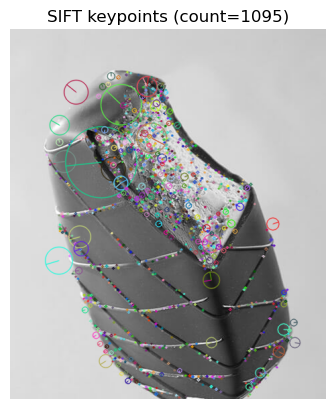

Prompt: Describe patterns in keypoint locations and orientations.


In [9]:
# SIFT detection
try:
    sift = cv2.SIFT_create() 
except AttributeError as e:
    sift = None
    print("SIFT is not available in this environment. Install opencv-contrib-python to enable SIFT.")
    print("Error:", e)

if sift is not None:
    kps, desc = sift.detectAndCompute(image_gray, None)
    # Draw with rich flags (size/orientation)
    sift_vis = cv2.drawKeypoints(image_gray, kps, None,
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(sift_vis, cmap='gray')
    plt.title(f"SIFT keypoints (count={len(kps)})")
    plt.axis('off')
    plt.show()
    print("Prompt: Describe patterns in keypoint locations and orientations.")


---
## Question 4 

**Task:** **Brute Force Matching** between two modified versions of our image.  
- Create duplicates:
  - `matching_image1`: resized (fx=fy=1.6)  
  - `matching_image2`: rotated 90° clockwise  
- Detect SIFT features in both, then **BFMatcher.knnMatch** with `k=2`  
- Use a standard **Lowe ratio test** to filter matches  
- Draw matches with `cv2.drawMatchesKnn` and display  


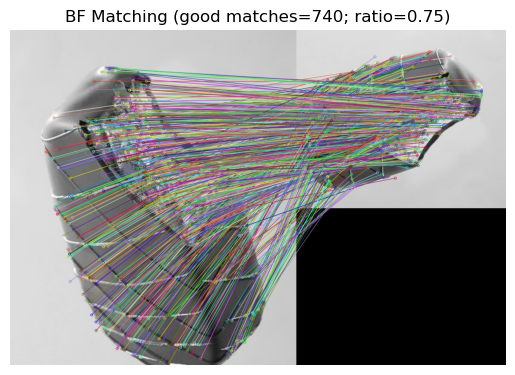

In [11]:
# Prepare matching images
matching_image1 = cv2.resize(image_gray, (0,0), fx=1.6, fy=1.6, interpolation=cv2.INTER_LINEAR)
matching_image2 = cv2.rotate(image_gray, cv2.ROTATE_90_CLOCKWISE)

if sift is None:
    print("SIFT unavailable; skip matching. Install opencv-contrib-python to proceed.")
else:
    # Detect & compute
    kps1, des1 = sift.detectAndCompute(matching_image1, None)
    kps2, des2 = sift.detectAndCompute(matching_image2, None)

    # Brute Force matcher (L2 for SIFT)
    bf = cv2.BFMatcher(cv2.NORM_L2)
    raw_matches = bf.knnMatch(des1, des2, k=2)

    # Lowe ratio test
    good = []
    ratio = 0.75
    for m,n in raw_matches:
        if m.distance < ratio * n.distance:
            good.append([m])  # drawMatchesKnn expects list of lists

    matched_image = cv2.drawMatchesKnn(matching_image1, kps1, matching_image2, kps2, good, None,
                                       flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(matched_image, cmap='gray')
    plt.title(f"BF Matching (good matches={len(good)}; ratio={ratio})")
    plt.axis('off')
    plt.show()

---
## Question 5

**Task:** **FLANN** vs **Brute Force** timing comparison over different SIFT `nfeatures`.  
- For `nfeatures` in `[100, 250, 500, 750, 1000, 2000]`:
  - Create SIFT with that `nfeatures`
  - Detect+compute on `matching_image1` and `matching_image2`
  - Time **BFMatcher.knnMatch** and **FlannBasedMatcher.knnMatch**
- Plot times vs number of features


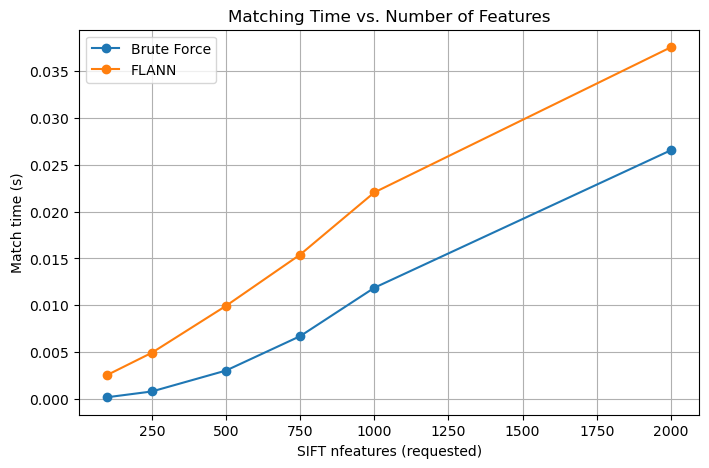

In [12]:
import time

if sift is None:
    print("SIFT unavailable; skip FLANN comparison. Install opencv-contrib-python to proceed.")
else:
    feature_counts = [100, 250, 500, 750, 1000, 2000]
    times_bf = []
    times_flann = []

    for n in feature_counts:
        sift_n = cv2.SIFT_create(nfeatures=n)

        kps1_n, des1_n = sift_n.detectAndCompute(matching_image1, None)
        kps2_n, des2_n = sift_n.detectAndCompute(matching_image2, None)

        # If not enough descriptors, append NaN and continue
        if des1_n is None or des2_n is None or len(des1_n) < 2 or len(des2_n) < 2:
            times_bf.append(np.nan)
            times_flann.append(np.nan)
            continue

        # Brute Force timing
        bf = cv2.BFMatcher(cv2.NORM_L2)
        t0 = time.time()
        _ = bf.knnMatch(des1_n, des2_n, k=2)
        t1 = time.time()
        times_bf.append(t1 - t0)

        # FLANN timing (KD-Tree for SIFT float descriptors)
        index_params = dict(algorithm=1, trees=5)  # FLANN_INDEX_KDTREE = 1
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        t2 = time.time()
        _ = flann.knnMatch(des1_n, des2_n, k=2)
        t3 = time.time()
        times_flann.append(t3 - t2)

    # Plot timing results
    plt.figure(figsize=(8,5))
    plt.plot(feature_counts, times_bf, marker='o', label='Brute Force')
    plt.plot(feature_counts, times_flann, marker='o', label='FLANN')
    plt.xlabel("SIFT nfeatures (requested)")
    plt.ylabel("Match time (s)")
    plt.title("Matching Time vs. Number of Features")
    plt.legend()
    plt.grid(True)
    plt.show()
